In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier

### **Data Exploration**

In [121]:
# Load the dataset
vehicle_df = pd.read_csv('vehicle.csv')
vehicle_df.info()
vehicle_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        497 non-null    object 
 1   Zip Code    497 non-null    float64
 2   Model Year  497 non-null    object 
 3   Fuel        497 non-null    object 
 4   Make        496 non-null    object 
 5   Light_Duty  496 non-null    object 
 6   Vehicles    496 non-null    float64
dtypes: float64(2), object(5)
memory usage: 27.4+ KB


,Date,Zip Code,Model Year,Fuel,Make,Light_Duty,Vehicles
0,10/1/2018,90000.0,2006,Gasoline,OTHER/UNK,NaN,1.0
1,10/1/2018,NaN,2014,Gasoline,NaN,Yes,1.0
2,NaN,90000.0,NaN,Gasoline,OTHER/UNK,Yes,NaN
3,10/1/2018,90000.0,2017,Gasoline,OTHER/UNK,Yes,1.0
4,10/1/2018,90000.0,<2006,Diesel and Diesel Hybrid,OTHER/UNK,No,55.0


In [122]:
# Count the duplicates
vehicle_df.duplicated().sum()

0

In [123]:
# Count the missing values
vehicle_df.isna().sum()

Date          2
Zip Code      2
Model Year    2
Fuel          2
Make          3
Light_Duty    3
Vehicles      3
dtype: int64

In [124]:
# Count the unique values
vehicle_df.nunique()

Date          130
Zip Code        4
Model Year     15
Fuel            8
Make           43
Light_Duty      2
Vehicles      151
dtype: int64

In [141]:
# Count the number of samples for each class in 'Light_Duty'
vehicle_df['Light_Duty'].value_counts()

Light_Duty
Yes    436
No      63
Name: count, dtype: int64

### **Data Visualization**

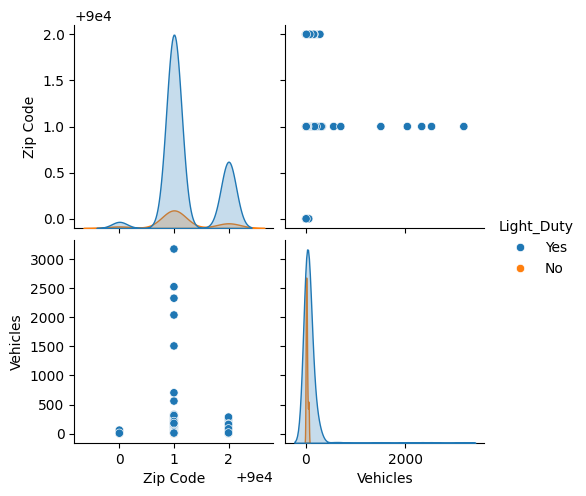

In [126]:
# Pairplot can only visualize numerical data
sns.pairplot(vehicle_df, hue='Light_Duty')

### **Data Preprocessing**

In [127]:
# Convert 'Date' to datetime format
vehicle_df['Date'] = pd.to_datetime(vehicle_df['Date'])

# Extract the day, month, and year from 'Date'
vehicle_df['Day'] = vehicle_df['Date'].dt.day
vehicle_df['Month'] = vehicle_df['Date'].dt.month
vehicle_df['Year'] = vehicle_df['Date'].dt.year
vehicle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        497 non-null    datetime64[ns]
 1   Zip Code    497 non-null    float64       
 2   Model Year  497 non-null    object        
 3   Fuel        497 non-null    object        
 4   Make        496 non-null    object        
 5   Light_Duty  496 non-null    object        
 6   Vehicles    496 non-null    float64       
 7   Day         497 non-null    float64       
 8   Month       497 non-null    float64       
 9   Year        497 non-null    float64       
dtypes: datetime64[ns](1), float64(5), object(4)
memory usage: 39.1+ KB


In [128]:
# Fill the missing values using the backfill method
vehicle_df.bfill(inplace=True)
vehicle_df.isna().sum()

Date          0
Zip Code      0
Model Year    0
Fuel          0
Make          0
Light_Duty    0
Vehicles      0
Day           0
Month         0
Year          0
dtype: int64

In [129]:
# Drop the unncecessary features
vehicle_df = vehicle_df.drop(columns=['Date', 'Vehicles', 'Zip Code'])
vehicle_df.head()

,Model Year,Fuel,Make,Light_Duty,Day,Month,Year
0,2006,Gasoline,OTHER/UNK,Yes,1.0,10.0,2018.0
1,2014,Gasoline,OTHER/UNK,Yes,1.0,10.0,2018.0
2,2017,Gasoline,OTHER/UNK,Yes,1.0,10.0,2018.0
3,2017,Gasoline,OTHER/UNK,Yes,1.0,10.0,2018.0
4,<2006,Diesel and Diesel Hybrid,OTHER/UNK,No,1.0,10.0,2018.0


In [130]:
# Select categorical features except the target variable
categorical_columns = vehicle_df.drop(columns='Light_Duty').select_dtypes(include=['object']).columns

le = LabelEncoder()
# Transform the categorical columns into numerical columns
# Use loop to maintain the column names
for column in categorical_columns:
    vehicle_df[column] = le.fit_transform(vehicle_df[column])

vehicle_df.head()

,Model Year,Fuel,Make,Light_Duty,Day,Month,Year
0,0,3,0,Yes,1.0,10.0,2018.0
1,8,3,0,Yes,1.0,10.0,2018.0
2,11,3,0,Yes,1.0,10.0,2018.0
3,11,3,0,Yes,1.0,10.0,2018.0
4,14,1,0,No,1.0,10.0,2018.0


In [131]:
# Standardize the numerical features except the target variable since it is binary
columns = vehicle_df.drop(columns='Light_Duty').columns

std_scaler = StandardScaler()
vehicle_df[columns] = std_scaler.fit_transform(vehicle_df[columns])
vehicle_df.head()

,Model Year,Fuel,Make,Light_Duty,Day,Month,Year
0,-1.446399,0.218104,-1.038922,Yes,-1.501945,0.655069,-0.821277
1,0.237972,0.218104,-1.038922,Yes,-1.501945,0.655069,-0.821277
2,0.869612,0.218104,-1.038922,Yes,-1.501945,0.655069,-0.821277
3,0.869612,0.218104,-1.038922,Yes,-1.501945,0.655069,-0.821277
4,1.501251,-1.760692,-1.038922,No,-1.501945,0.655069,-0.821277


### **Model Training**

In [144]:
# Split the dataset into features and target variable
X = vehicle_df.drop(columns=['Light_Duty'])
y = vehicle_df['Light_Duty']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the number of training and testing samples
print(f'Training: {X_train.shape[0]}')
print(f'Testing: {X_test.shape[0]}')

Training: 399
Testing: 100


In [133]:
# Train the model
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

### **Model Evaluation**

In [134]:
# Calculate the accuracy
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.89


In [140]:
# Display the classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

          No       0.33      0.57      0.42         7
         Yes       0.97      0.91      0.94        93

    accuracy                           0.89       100
   macro avg       0.65      0.74      0.68       100
weighted avg       0.92      0.89      0.90       100



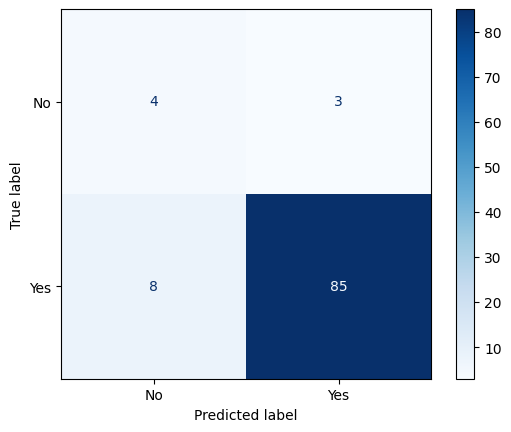

In [136]:
# Visulize the confusion matrix
model_class = model.classes_
cm = confusion_matrix(y_test, y_pred)

matrix = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_class)
matrix.plot(cmap=plt.cm.Blues)